<a href="https://colab.research.google.com/github/dpqhd01/medical_cap/blob/main/%EC%9E%84%EB%B2%A0%EB%94%A9_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B2%84%EC%A0%842%EB%A1%9C_45%EB%A7%8C%EA%B1%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import requests
import pandas as pd
from tqdm import tqdm
import time
import sys

# Drive 마운트
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/' # Drive 내 프로젝트 폴더 설정
os.makedirs(DRIVE_PATH, exist_ok=True)
print(f"✅ Drive 저장 경로 설정 완료: {DRIVE_PATH}")

Mounted at /content/drive
✅ Drive 저장 경로 설정 완료: /content/drive/MyDrive/Colab_450k_Project/


In [ ]:
# Gemma 사용을 위해 Hugging Face 트랜스포머 라이브러리 및 관련 의존성 설치
!pip install transformers accelerate bitsandbytes
# ClinicalTrials.gov API 호출 및 데이터 처리를 위한 필수 라이브러리
!pip install requests pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.9 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
import time
import os

# ⚠️ [확인]: DRIVE_PATH 변수가 이전 셀에서 정의되었음을 가정합니다.
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'

# --- 환경 설정 ---
BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
PAGE_SIZE = 10000
MAX_STUDIES = 450000

all_criteria_list = []
next_page_token = None

print(f"\n⏳ ClinicalTrials.gov API에서 최대 {MAX_STUDIES}개의 Trial 데이터를 가져옵니다...")

# 페이지네이션을 위한 반복문
for i in tqdm(range(0, MAX_STUDIES, PAGE_SIZE), desc="Trial 데이터 페이지 로드 중"):
    params = {
        "sort": "LastUpdatePostDate:desc",
        "pageSize": PAGE_SIZE,
    }
    if next_page_token:
        params["pageToken"] = next_page_token

    try:
        response = requests.get(BASE_URL, params=params, timeout=120)
        response.raise_for_status()
        data = response.json()

        for study in data.get('studies', []):
            try:
                criteria = study['protocolSection']['eligibilityModule']['eligibilityCriteria']
                all_criteria_list.append({'eligibilityCriteria': criteria})
            except KeyError:
                continue

        next_page_token = data.get('nextPageToken')

        if not next_page_token or len(all_criteria_list) >= MAX_STUDIES:
            break

        time.sleep(1) # API 부하 방지

    except Exception as e:
        print(f"\n🔥🔥 오류: API 호출 중단 (현재 {len(all_criteria_list)}개 확보): {e}")
        break

print(f"\n✅ API로부터 총 {len(all_criteria_list)}개의 Trial 텍스트를 성공적으로 가져왔습니다.")

# ⚠️ [Drive 저장]: 최종 결과를 Drive 경로에 저장
trials_df_full = pd.DataFrame(all_criteria_list)
FILE_NAME = "trials_api_450k_data.csv"
trials_df_full.to_csv(os.path.join(DRIVE_PATH, FILE_NAME), index=False, encoding='utf-8-sig')

print(f"✅ '{FILE_NAME}' 파일이 Drive에 저장 완료되었습니다! 이제 Step 2로 진행하세요.")


⏳ ClinicalTrials.gov API에서 최대 450000개의 Trial 데이터를 가져옵니다...


Trial 데이터 페이지 로드 중: 100%|██████████| 45/45 [01:27<00:00,  1.95s/it]



✅ API로부터 총 44874개의 Trial 텍스트를 성공적으로 가져왔습니다.
✅ 'trials_api_450k_data.csv' 파일이 Drive에 저장 완료되었습니다! 이제 Step 2로 진행하세요.


In [ ]:
!pip install sentence-transformers pandas numpy torch tqdm

from google.colab import drive
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm
import sys

# ⚠️ [확인]: DRIVE_PATH 변수가 이전 셀에서 정의되었음을 가정
# 만약 Drive 경로 변수가 정의되지 않았다면, 아래 경로를 직접 입력하세요.
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'

def normalize_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip().lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

# --- 파일 로드 ---
print("⏳ 1단계: 45만 건 Trial 및 HPO 파일을 로드합니다...")
try:
    # ⚠️ Drive에서 파일 로드 경로 명시
    trials_df = pd.read_csv(os.path.join(DRIVE_PATH, "trials_api_450k_data.csv"))
    hpo_df = pd.read_csv("/out4.csv")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'을 확인하세요. Step 1을 완료하고 Drive에 저장했는지 확인하세요.")
    sys.exit(1)

# --- 텍스트 추출 및 정규화 ---
print("⏳ 2단계: 텍스트 정규화 및 임베딩 준비...")
# unique()를 사용하여 중복 텍스트 제거 (메모리 절약)
trials_criteria_raw = trials_df['eligibilityCriteria'].dropna().unique().tolist()
hpo_terms_raw = hpo_df['HPOTERM'].dropna().unique().tolist()

trials_criteria_normalized = [normalize_text(c) for c in trials_criteria_raw]
hpo_terms_normalized = [normalize_text(t) for t in hpo_terms_raw]
print(f"정규화된 Trial (Unique): {len(trials_criteria_normalized)}, HPO (Unique): {len(hpo_terms_normalized)}")

# --- 임베딩 모델 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 임베딩 장치 설정 완료: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 3단계: 임베딩 생성 (RAM 한계 도전 구간) ---
BATCH_SIZE = 128
print(f"\n⚠️ 경고: 45만 건 임베딩을 한 번에 처리합니다. (RAM 한계 초과 위험 높음, {device} 사용)")

print("⏳ Trial Criteria 임베딩 생성 중...")
trial_embeddings = model.encode(trials_criteria_normalized, show_progress_bar=True, batch_size=BATCH_SIZE, convert_to_numpy=True)

print("⏳ HPO Terms 임베딩 생성 중...")
hpo_embeddings = model.encode(hpo_terms_normalized, show_progress_bar=True, batch_size=BATCH_SIZE, convert_to_numpy=True)

# --- 4단계: 최종 파일 저장 (Drive에 즉시 저장) ---
print("\n✅ 임베딩 생성 완료! 파일을 Drive에 저장합니다...")

# 최종 파일 저장 (Drive 경로 명시!)
pd.DataFrame({'original_text': trials_criteria_normalized}).to_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"), index=False)
pd.DataFrame({'original_text': hpo_terms_normalized}).to_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"), index=False)

np.save(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), trial_embeddings)
np.save(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), hpo_embeddings)

print("\n🎉🎉🎉 모든 임베딩 파일이 Drive에 성공적으로 저장되었습니다! 다음 Step 3으로 진행하세요. 🎉🎉🎉")

⏳ 1단계: 45만 건 Trial 및 HPO 파일을 로드합니다...
⏳ 2단계: 텍스트 정규화 및 임베딩 준비...
정규화된 Trial (Unique): 44721, HPO (Unique): 8697
✅ 임베딩 장치 설정 완료: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


⚠️ 경고: 45만 건 임베딩을 한 번에 처리합니다. (RAM 한계 초과 위험 높음, cpu 사용)
⏳ Trial Criteria 임베딩 생성 중...


Batches:   0%|          | 0/350 [00:00<?, ?it/s]

⏳ HPO Terms 임베딩 생성 중...


Batches:   0%|          | 0/68 [00:00<?, ?it/s]


✅ 임베딩 생성 완료! 파일을 Drive에 저장합니다...

🎉🎉🎉 모든 임베딩 파일이 Drive에 성공적으로 저장되었습니다! 다음 Step 3으로 진행하세요. 🎉🎉🎉


스탭 3부분만 속도개선 버전2 학습데이터 생성용으로 바꿈.(사실 그 전 임베딩 단계들은 같았음)

In [ ]:
import pandas as pd
import random
from tqdm import tqdm
import sys
import os

# ⚠️ [확인]: DRIVE_PATH 변수가 이전 셀에서 정의되었음을 가정
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'

# V2 핵심: 텍스트 정규화 함수 (Step 2와 완벽히 동일해야 함!)
def normalize_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip().lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

# --- 파일 로드 (수정된 부분) ---
print("⏳ 1단계: 원본 파일 로드 및 정규화...")
try:
    # ⚠️ [수정]: Drive 경로를 명시하여 로드
    trials_df = pd.read_csv(os.path.join(DRIVE_PATH, "trials_api_450k_data.csv"))
    hpo_df = pd.read_csv(os.path.join(DRIVE_PATH, "out4.csv"))
    print("✅ 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)

# ⚠️ [수정 핵심]: 원본 텍스트에 정규화 함수를 적용
trials_criteria_raw = trials_df['eligibilityCriteria'].dropna().tolist()
hpo_terms_raw = hpo_df['HPOTERM'].dropna().tolist()

trials_criteria = [normalize_text(c) for c in trials_criteria_raw]
hpo_terms = [normalize_text(t) for t in hpo_terms_raw]

training_data = []
seen_pairs = set()
MAX_FINAL_PAIRS = 2000000

# --- 긍정 예시 (Label = 1) 생성 [✨ 속도 최적화] ---
print("⏳ 2단계: 긍정 데이터 생성 중 (속도 최적화된 검색 방식)...")

for term in tqdm(hpo_terms, desc="HPO 용어 기준으로 긍정 데이터 검색 중"):
    if len(term) >= 3:
        for criteria in trials_criteria:
            if term in criteria:
                pair = (criteria, term)
                if pair not in seen_pairs:
                    training_data.append({'text_A': criteria, 'text_B': term, 'label': 1})
                    seen_pairs.add(pair)

                # 긍정 쌍이 목표 개수의 절반에 도달하면 중단
                if len(training_data) >= MAX_FINAL_PAIRS // 2:
                    break
        if len(training_data) >= MAX_FINAL_PAIRS // 2:
            break

num_positive_samples = len(training_data)
print(f"✅ 긍정 데이터 {num_positive_samples}개 생성 완료! (목표: {MAX_FINAL_PAIRS // 2}개)")


# --- 부정 예시 (Label = 0) 생성 (1:1 비율 유지) ---
print(f"⏳ 3단계: 부정 데이터 생성 중 (긍정 데이터와 1:1 비율)...")
NUM_NEGATIVE_SAMPLES = num_positive_samples

negative_count = 0
with tqdm(total=NUM_NEGATIVE_SAMPLES, desc="부정 데이터 생성 중") as pbar:
    while negative_count < NUM_NEGATIVE_SAMPLES:
        random_criteria = random.choice(trials_criteria)
        random_term = random.choice(hpo_terms)

        if len(random_term) >= 3 and random_term in random_criteria:
            continue

        pair = (random_criteria, random_term)
        if pair not in seen_pairs:
            training_data.append({'text_A': random_criteria, 'text_B': random_term, 'label': 0})
            seen_pairs.add(pair)
            negative_count += 1
            pbar.update(1)
print(f"✅ 부정 데이터 {negative_count}개 생성 완료!")

# --- 최종 CSV 파일로 저장 (Drive 저장 추가) ---
print("\n⏳ 4단계: 'training_data_450k_v2.csv' 파일로 저장합니다...")
final_df = pd.DataFrame(training_data)
final_df = final_df.sample(frac=1).reset_index(drop=True)

# ⚠️ [수정 핵심]: Drive 경로에 저장
final_df.to_csv(os.path.join(DRIVE_PATH, "training_data_450k_v2.csv"), index=False, encoding='utf-8-sig')

print("\n🎉🎉🎉 성공! 'training_data_450k_v2.csv' 파일이 Drive에 생성되었습니다! 🎉🎉🎉")
print(f"총 {len(final_df)}개의 균형 잡힌 학습 데이터가 만들어졌습니다.")

⏳ 1단계: 원본 파일 로드 및 정규화...
✅ 파일 로드 완료!
⏳ 2단계: 긍정 데이터 생성 중 (속도 최적화된 검색 방식)...


HPO 용어 기준으로 긍정 데이터 검색 중: 100%|██████████| 115627/115627 [3:21:07<00:00,  9.58it/s]


✅ 긍정 데이터 218385개 생성 완료! (목표: 1000000개)
⏳ 3단계: 부정 데이터 생성 중 (긍정 데이터와 1:1 비율)...


부정 데이터 생성 중: 100%|██████████| 218385/218385 [00:01<00:00, 137399.75it/s]


✅ 부정 데이터 218385개 생성 완료!

⏳ 4단계: 'training_data_450k_v2.csv' 파일로 저장합니다...

🎉🎉🎉 성공! 'training_data_450k_v2.csv' 파일이 Drive에 생성되었습니다! 🎉🎉🎉
총 436770개의 균형 잡힌 학습 데이터가 만들어졌습니다.


샴 LSTM 450k
근데 데이터가 너무 많아서 원래 코드 아니고 뭔갈 많이 수정해서 진행함

✅ Device: cpu
⏳ 1단계: 4.5만 건 V2 학습 데이터 및 임베딩 파일 로드...
✅ 4.5만 건 V2 파일 로드 완료!
⏳ 2단계: Siamese 구조를 위한 벡터 쌍 분리 생성...


데이터 쌍 벡터화 중: 100%|██████████| 436770/436770 [00:29<00:00, 14660.56it/s]



✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.
✅ 학습 데이터: 349416개, 테스트 데이터: 87354개

✅ Siamese LSTM 모델 정의 완료! 대규모 데이터 학습을 시작합니다...


Epoch 1/10 [학습]: 100%|██████████| 5459/5459 [01:46<00:00, 51.40it/s]


Epoch [1/10] | Loss: 0.6684 | Val F1: 0.8183


Epoch 2/10 [학습]: 100%|██████████| 5459/5459 [01:48<00:00, 50.12it/s]


Epoch [2/10] | Loss: 0.4778 | Val F1: 0.8317


Epoch 3/10 [학습]: 100%|██████████| 5459/5459 [01:52<00:00, 48.64it/s]


Epoch [3/10] | Loss: 0.3793 | Val F1: 0.8451


Epoch 4/10 [학습]: 100%|██████████| 5459/5459 [01:54<00:00, 47.65it/s]


Epoch [4/10] | Loss: 0.3530 | Val F1: 0.8565


Epoch 5/10 [학습]: 100%|██████████| 5459/5459 [01:58<00:00, 46.24it/s]


Epoch [5/10] | Loss: 0.3378 | Val F1: 0.8628


Epoch 6/10 [학습]: 100%|██████████| 5459/5459 [02:00<00:00, 45.33it/s]


Epoch [6/10] | Loss: 0.3265 | Val F1: 0.8679


Epoch 7/10 [학습]: 100%|██████████| 5459/5459 [01:54<00:00, 47.79it/s]


Epoch [7/10] | Loss: 0.3171 | Val F1: 0.8721


Epoch 8/10 [학습]: 100%|██████████| 5459/5459 [01:49<00:00, 49.96it/s]


Epoch [8/10] | Loss: 0.3100 | Val F1: 0.8754


Epoch 9/10 [학습]: 100%|██████████| 5459/5459 [01:50<00:00, 49.28it/s]


Epoch [9/10] | Loss: 0.3030 | Val F1: 0.8776


Epoch 10/10 [학습]: 100%|██████████| 5459/5459 [01:49<00:00, 49.70it/s]


Epoch [10/10] | Loss: 0.2962 | Val F1: 0.8805

=== 최종 Classification Report (Siamese LSTM Encoder - 55.9k Data) ===
              precision    recall  f1-score   support

         0.0     0.8834    0.8757    0.8795     43652
         1.0     0.8767    0.8844    0.8805     43644

    accuracy                         0.8800     87296
   macro avg     0.8800    0.8800    0.8800     87296
weighted avg     0.8800    0.8800    0.8800     87296


⏳ 학습 과정 시각화 중...


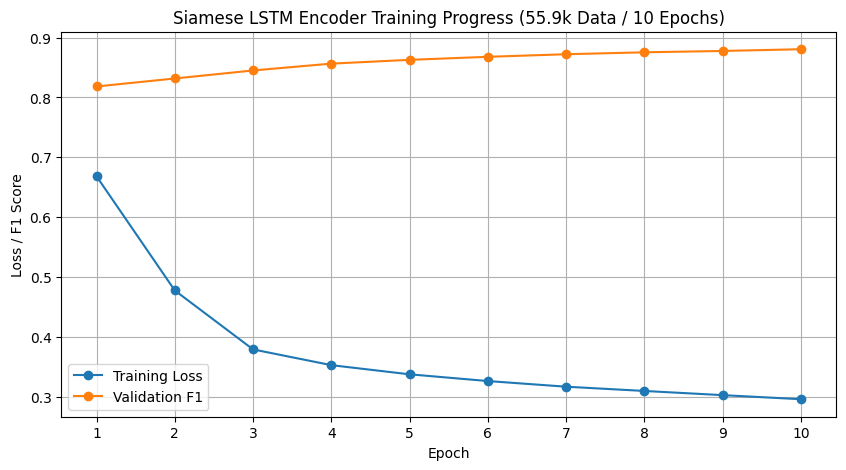

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}") # GPU(T4)로 설정되었는지 확인하세요!

# Drive 경로 (이전 셀에서 정의됨)
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'

# --- 1. 파일 로드 ---
print("⏳ 1단계: 4.5만 건 V2 학습 데이터 및 임베딩 파일 로드...")
try:
    training_df = pd.read_csv(os.path.join(DRIVE_PATH, "training_data_450k_v2.csv"))
    trial_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"))
    hpo_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"))
    trial_embeddings = np.load(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), allow_pickle=True)
    hpo_embeddings = np.load(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), allow_pickle=True)
    print("✅ 4.5만 건 V2 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)

# 임베딩 딕셔너리 생성
trial_embed_map = dict(zip(trial_keys_df['original_text'], trial_embeddings))
hpo_embed_map = dict(zip(hpo_keys_df['original_text'], hpo_embeddings))

# --- 2. 벡터 쌍 생성 (Siamese 구조) ---
print("⏳ 2단계: Siamese 구조를 위한 벡터 쌍 분리 생성...")
X_A = [] # Criteria 벡터
X_B = [] # HPO Term 벡터
labels = []
mismatch_count = 0

for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 벡터화 중"):
    text_A = str(row['text_A'])
    text_B = str(row['text_B'])
    label = row['label']

    vector_A = trial_embed_map.get(text_A)
    vector_B = hpo_embed_map.get(text_B)

    if vector_A is not None and vector_B is not None:
        X_A.append(vector_A.astype(np.float32))
        X_B.append(vector_B.astype(np.float32))
        labels.append(label)
    else:
        mismatch_count += 1

if mismatch_count > 0:
    print(f"\n🔥🔥 경고: {mismatch_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다.")
else:
    print("\n✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.")

X_A = np.array(X_A)
X_B = np.array(X_B)
y = np.array(labels)

if len(X_A) == 0:
    print("🔥🔥 오류: 유효한 벡터 쌍이 없어 모델 학습을 진행할 수 없습니다.")
    sys.exit(1)

embedding_dim = X_A.shape[1]

# --- 3. 데이터셋 분할 ---
X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = train_test_split(
    X_A, X_B, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ 학습 데이터: {len(X_A_train)}개, 테스트 데이터: {len(X_A_test)}개")


# ======================================#
# 4️⃣ Siamese LSTM 모델 정의
# ======================================
# Dataset 정의
class SiameseEmbeddingDataset(Dataset):
    def __init__(self, X_A, X_B, y):
        self.X_A = torch.tensor(X_A, dtype=torch.float32)
        self.X_B = torch.tensor(X_B, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X_A)
    def __getitem__(self, idx): return self.X_A[idx], self.X_B[idx], self.y[idx]

train_ds = SiameseEmbeddingDataset(X_A_train, X_B_train, y_train)
test_ds = SiameseEmbeddingDataset(X_A_test, X_B_test, y_test)

# ⚠️ [수정]: drop_last=True 를 추가하여 마지막 불완전한 배치를 버립니다.
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=64, drop_last=True)


# Siamese Network의 기본 인코더 (LSTM)
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, output_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        out = self.dropout(h.squeeze(0))
        return out

# Siamese Network 최종 모델
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(SiameseNetwork, self).__init__()
        self.shared_encoder = LSTMEncoder(input_dim, output_dim=hidden_dim)

        self.fc_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x1, x2):
        encoded_x1 = self.shared_encoder(x1)
        encoded_x2 = self.shared_encoder(x2)
        diff = torch.abs(encoded_x1 - encoded_x2)
        out = self.fc_classifier(diff)
        return torch.sigmoid(out).squeeze(-1)

# 모델, 손실 함수, 옵티마이저 정의
model = SiameseNetwork(input_dim=embedding_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print("\n✅ Siamese LSTM 모델 정의 완료! 대규모 데이터 학습을 시작합니다...")

# --- 5. 학습 루프 및 평가 ---
EPOCHS = 10
train_loss_list, val_f1_list = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb_A, Xb_B, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
        Xb_A, Xb_B, yb = Xb_A.to(device), Xb_B.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb_A, Xb_B)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # --- 검증 단계 ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xb_A, Xb_B, yb in test_loader:
            Xb_A, Xb_B = Xb_A.to(device), Xb_B.to(device)
            # 이제 test_loader는 항상 64개씩 반환하므로 오류가 발생하지 않습니다.
            probs = model(Xb_A, Xb_B).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            if preds.ndim == 0:
                all_preds.append(int(preds))
            else:
                all_preds.extend(preds.tolist())
            all_labels.extend(yb.numpy().tolist())

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    val_f1_list.append(f1)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f}")

# --- 6. 최종 평가 ---
print("\n=== 최종 Classification Report (Siamese LSTM Encoder - 55.9k Data) ===")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

# --- 7. 시각화 ---
print("\n⏳ 학습 과정 시각화 중...")
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
plt.title(f"Siamese LSTM Encoder Training Progress (55.9k Data / {EPOCHS} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss / F1 Score")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.grid(True)
plt.show()

샴 MLP 450k

✅ Device: cpu
✅ 모델 저장 경로: /content/drive/MyDrive/Colab_450k_Project/MLP_Checkpoints/
✅ 450k V2 (4.5만 건) 파일 로드 완료!
Training Data shape: (436770, 3)
✅ 새로운 임베딩 차원: 384

⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...


데이터 쌍 생성 중: 100%|██████████| 436770/436770 [00:28<00:00, 15334.63it/s]


✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.
✅ 학습 데이터: 349416개, 테스트 데이터: 87354개

✅ Siamese MLP 모델 정의 완료!

⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...


Epoch 1/10 [학습]: 100%|██████████| 5460/5460 [00:43<00:00, 126.62it/s]


  ✨ **CheckPoint 저장됨**: Epoch 1, F1: 0.8502 (Google Drive)
Epoch [1/10] | Loss: 0.5203 | Val F1: 0.8502 (Best F1: 0.8502)


Epoch 2/10 [학습]: 100%|██████████| 5460/5460 [00:40<00:00, 134.84it/s]


  ✨ **CheckPoint 저장됨**: Epoch 2, F1: 0.8688 (Google Drive)
Epoch [2/10] | Loss: 0.3496 | Val F1: 0.8688 (Best F1: 0.8688)


Epoch 3/10 [학습]: 100%|██████████| 5460/5460 [00:47<00:00, 114.68it/s]


  ✨ **CheckPoint 저장됨**: Epoch 3, F1: 0.8781 (Google Drive)
Epoch [3/10] | Loss: 0.3248 | Val F1: 0.8781 (Best F1: 0.8781)


Epoch 4/10 [학습]: 100%|██████████| 5460/5460 [00:44<00:00, 123.81it/s]


  ✨ **CheckPoint 저장됨**: Epoch 4, F1: 0.8826 (Google Drive)
Epoch [4/10] | Loss: 0.3096 | Val F1: 0.8826 (Best F1: 0.8826)


Epoch 5/10 [학습]: 100%|██████████| 5460/5460 [00:42<00:00, 129.55it/s]


  ✨ **CheckPoint 저장됨**: Epoch 5, F1: 0.8860 (Google Drive)
Epoch [5/10] | Loss: 0.2986 | Val F1: 0.8860 (Best F1: 0.8860)


Epoch 6/10 [학습]: 100%|██████████| 5460/5460 [00:41<00:00, 132.82it/s]


  ✨ **CheckPoint 저장됨**: Epoch 6, F1: 0.8894 (Google Drive)
Epoch [6/10] | Loss: 0.2897 | Val F1: 0.8894 (Best F1: 0.8894)


Epoch 7/10 [학습]: 100%|██████████| 5460/5460 [00:39<00:00, 136.58it/s]


  ✨ **CheckPoint 저장됨**: Epoch 7, F1: 0.8923 (Google Drive)
Epoch [7/10] | Loss: 0.2823 | Val F1: 0.8923 (Best F1: 0.8923)


Epoch 8/10 [학습]: 100%|██████████| 5460/5460 [00:40<00:00, 134.17it/s]


  ✨ **CheckPoint 저장됨**: Epoch 8, F1: 0.8948 (Google Drive)
Epoch [8/10] | Loss: 0.2760 | Val F1: 0.8948 (Best F1: 0.8948)


Epoch 9/10 [학습]: 100%|██████████| 5460/5460 [00:44<00:00, 123.53it/s]


  ✨ **CheckPoint 저장됨**: Epoch 9, F1: 0.8963 (Google Drive)
Epoch [9/10] | Loss: 0.2711 | Val F1: 0.8963 (Best F1: 0.8963)


Epoch 10/10 [학습]: 100%|██████████| 5460/5460 [00:41<00:00, 130.14it/s]


  ✨ **CheckPoint 저장됨**: Epoch 10, F1: 0.8982 (Google Drive)
Epoch [10/10] | Loss: 0.2671 | Val F1: 0.8982 (Best F1: 0.8982)

=== 최종 Classification Report (Siamese MLP Encoder - 450k V2 Data) ===
              precision    recall  f1-score   support

         0.0     0.9155    0.8719    0.8932     43677
         1.0     0.8778    0.9196    0.8982     43677

    accuracy                         0.8958     87354
   macro avg     0.8967    0.8958    0.8957     87354
weighted avg     0.8967    0.8958    0.8957     87354



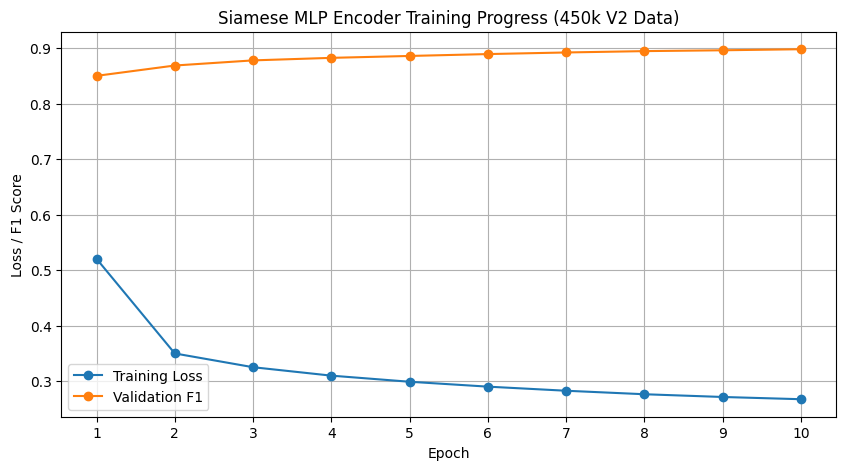

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ⚠️ [수정]: 450k V2 데이터가 저장된 Drive 경로
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'
MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'MLP_Checkpoints/')
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✅ 모델 저장 경로: {MODEL_SAVE_PATH}")


# ======================================#
# 1️⃣ CSV 불러오기 (450k V2 데이터로 수정)
# ======================================
try:
    # ⚠️ [수정]: 450k V2 파일명 사용 (이미지 목록 기준)
    training_df = pd.read_csv(os.path.join(DRIVE_PATH, "training_data_450k_v2.csv"))

    trial_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"))
    hpo_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"))

    # ⚠️ [수정]: .npy 파일로 벡터 로드
    trial_vecs = np.load(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), allow_pickle=True)
    hpo_vecs = np.load(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), allow_pickle=True)

    print("✅ 450k V2 (4.5만 건) 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)


# --- 1.2 임베딩 데이터 준비 (450k V2 방식) ---
print(f"Training Data shape: {training_df.shape}")

# ⚠️ [수정]: 텍스트-인덱스 딕셔너리 (키 파일 사용)
trial_text_to_idx = {str(text): idx for idx, text in enumerate(trial_keys_df['original_text'])}
hpo_text_to_idx = {str(text): idx for idx, text in enumerate(hpo_keys_df['original_text'])}

embedding_dim = trial_vecs.shape[1]
print(f"✅ 새로운 임베딩 차원: {embedding_dim}")

# ======================================#
# 2️⃣ 입력 시퀀스 생성 (Siamese 구조)
# ======================================
print("\n⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...")
X_A = [] # Criteria 벡터
X_B = [] # HPO Term 벡터
labels = []
mismatch_count = 0

for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 생성 중"):
    text_a = str(row['text_A'])
    text_b = str(row['text_B'])
    label = row['label']

    idx_a = trial_text_to_idx.get(text_a)
    idx_b = hpo_text_to_idx.get(text_b)

    if idx_a is not None and idx_b is not None:
        X_A.append(trial_vecs[idx_a])
        X_B.append(hpo_vecs[idx_b])
        labels.append(label)
    else:
        mismatch_count += 1

if mismatch_count > 0:
    print(f"⚠️ 경고: {mismatch_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다.")
else:
    print("✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.")

X_A = np.array(X_A)
X_B = np.array(X_B)
y = np.array(labels)

if len(X_A) > 0:
    # ======================================#
    # 3️⃣ Dataset 정의 (Siamese 구조)
    # ======================================
    class SiameseEmbeddingDataset(Dataset):
        def __init__(self, X_A, X_B, y):
            self.X_A = torch.tensor(X_A, dtype=torch.float32)
            self.X_B = torch.tensor(X_B, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self): return len(self.X_A)
        def __getitem__(self, idx):
            return self.X_A[idx], self.X_B[idx], self.y[idx]

    if len(np.unique(y)) < 2 or np.min(np.bincount(y)) < 2:
         print("🔥🔥 오류: 학습/테스트 데이터 분리 후 각 클래스에 샘플이 부족합니다. 데이터셋 크기를 확인하세요.")
         X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = [np.array([])]*6
    else:
        X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = train_test_split(
            X_A, X_B, y, test_size=0.2, random_state=42, stratify=y
        )

    if len(X_A_train) > 0 and len(X_A_test) > 0:
        train_ds = SiameseEmbeddingDataset(X_A_train, X_B_train, y_train)
        test_ds = SiameseEmbeddingDataset(X_A_test, X_B_test, y_test)

        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=64)
        print(f"✅ 학습 데이터: {len(X_A_train)}개, 테스트 데이터: {len(X_A_test)}개")

        # ======================================#
        # 4️⃣ Siamese MLP 모델 정의
        # ======================================

        class MLPEncoder(nn.Module):
            def __init__(self, input_dim, output_dim=128):
                super(MLPEncoder, self).__init__()
                self.fc1 = nn.Linear(input_dim, input_dim // 2)
                self.relu1 = nn.ReLU()
                self.dropout = nn.Dropout(0.3)
                self.fc2 = nn.Linear(input_dim // 2, output_dim)

            def forward(self, x):
                x = self.fc1(x)
                x = self.relu1(x)
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        class SiameseMLPNetwork(nn.Module):
            def __init__(self, input_dim, hidden_dim=128):
                super(SiameseMLPNetwork, self).__init__()
                self.shared_encoder = MLPEncoder(input_dim, output_dim=hidden_dim)

                self.fc_classifier = nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim // 2),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(hidden_dim // 2, 1)
                )

            def forward(self, x1, x2):
                encoded_x1 = self.shared_encoder(x1)
                encoded_x2 = self.shared_encoder(x2)

                diff = torch.abs(encoded_x1 - encoded_x2)

                out = self.fc_classifier(diff)

                return torch.sigmoid(out).squeeze(-1)

        # ⚠️ [수정]: 450k V2 데이터셋에 맞게 하이퍼파라미터 조정
        model = SiameseMLPNetwork(input_dim=embedding_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) # 학습률 1e-5로 조정
        print("\n✅ Siamese MLP 모델 정의 완료!")

        best_f1 = 0.0

        # ======================================#
        # 5️⃣ 학습 루프 (Siamese 구조)
        # ======================================
        EPOCHS = 10 # ⚠️ [수정]: 데이터셋이 크므로 10 Epochs로 조정
        train_loss_list, val_f1_list = [], []

        print("\n⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...")
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            for Xb_A, Xb_B, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
                Xb_A, Xb_B, yb = Xb_A.to(device), Xb_B.to(device), yb.to(device)

                optimizer.zero_grad()
                outputs = model(Xb_A, Xb_B)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            train_loss_list.append(avg_loss)

            # --- 검증 단계 ---
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xb_A, Xb_B, yb in test_loader:
                    Xb_A, Xb_B = Xb_A.to(device), Xb_B.to(device)
                    probs = model(Xb_A, Xb_B).cpu().numpy()
                    preds = (probs > 0.5).astype(int)

                    if preds.ndim == 0:
                        all_preds.append(int(preds))
                    else:
                        all_preds.extend(preds.tolist())

                    all_labels.extend(yb.numpy().tolist())

            f1 = f1_score(all_labels, all_preds, zero_division=0)
            val_f1_list.append(f1)

            # --- ✨ 체크포인트 저장 로직 ✨ ---
            if f1 > best_f1:
                best_f1 = f1
                model_path = os.path.join(MODEL_SAVE_PATH, f"Siamese_MLP_best_epoch_{epoch+1}_f1_{f1:.4f}.pth")
                torch.save(model.state_dict(), model_path)
                print(f"  ✨ **CheckPoint 저장됨**: Epoch {epoch+1}, F1: {f1:.4f} (Google Drive)")

            print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f} (Best F1: {best_f1:.4f})")

        # ======================================#
        # 6️⃣ 최종 평가 및 시각화
        # ======================================
        print("\n=== 최종 Classification Report (Siamese MLP Encoder - 450k V2 Data) ===")
        print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
        plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
        plt.title("Siamese MLP Encoder Training Progress (450k V2 Data)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss / F1 Score")
        plt.xticks(range(1, EPOCHS + 1))
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("🔥🔥 오류: 학습 또는 테스트 데이터셋 크기가 0입니다. 데이터 분리 설정을 확인하세요.")
else:
    print("🔥🔥 오류: 유효한 데이터 쌍이 없어 모델 학습을 진행할 수 없습니다.")

11-11 6:48 여기서 위쪽은 아빠 옛날 컴퓨터에서 버전2(속도개선)로 끝까지 돌려보는 거임!
데이터 파일 얻었고, 이제서야 샴 MLP / 샴 LSTM 인코더로 코드 변경할 거 수정하고서 돌려보았음.

11-12 10:24 Step 1 ClinicalTrials.gov API Dataset 불러오는 단계에서 4만건밖에 불러오지 않았던 사실 뒤늦게 발견.

==================================================================

11-12 10:30 아래 부터 Step 1부터 다시 실행.

In [ ]:
from google.colab import drive
import os

# Drive 마운트
drive.mount('/content/drive', force_remount=True)

# 새로운 프로젝트 폴더 경로 설정 (이전 파일과 분리)
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project_V2/'

# 폴더 생성
os.makedirs(DRIVE_PATH, exist_ok=True)
print(f"✅ Drive 저장 경로 설정 완료: {DRIVE_PATH}")

Mounted at /content/drive
✅ Drive 저장 경로 설정 완료: /content/drive/MyDrive/Colab_450k_Project_V2/


In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
import time
import sys
import os

# ⚠️ [확인]: 이전 셀에서 정의된 새로운 경로 사용
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project_V2/'

# --- 환경 설정 ---
BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
PAGE_SIZE = 10000
MAX_STUDIES = 450000 # 초기 목표 개수

# 1. API에 전체 개수(Total Count) 문의
print("🧐 API에 전체 데이터 개수를 문의합니다...")
try:
    count_params = {
        "countTotal": "true", # 총 개수를 요청
        "pageSize": 1         # 빠른 응답을 위해 1개만 요청
    }
    response = requests.get(BASE_URL, params=count_params, timeout=30)
    response.raise_for_status()
    data = response.json()

    total_count = data.get('totalCount')

    if total_count is not None:
        print(f"✅ API 서버가 인지하는 총 데이터 개수는: {total_count}개 입니다.")
        # 서버가 보고하는 개수를 최종 목표로 설정
        MAX_STUDIES = total_count
    else:
        print("🔥🔥 오류: API에서 totalCount 정보를 가져올 수 없습니다. 기본 목표 450000으로 진행합니다.")

except Exception as e:
    print(f"\n🔥🔥 오류: Total Count 확인 실패. 기본 목표 450000으로 진행합니다: {e}")
    # 오류 발생 시 기존 목표 유지
    total_count = MAX_STUDIES


# 2. 데이터 추출 (Total Count 기준으로 반복)
all_criteria_list = []
next_page_token = None

print(f"\n⏳ API가 보고한 최대 {MAX_STUDIES}개의 Trial 데이터를 가져옵니다...")

# 페이지네이션을 위한 반복문
# MAX_STUDIES가 total_count로 업데이트 되었을 것입니다.
for i in tqdm(range(0, MAX_STUDIES, PAGE_SIZE), desc="Trial 데이터 페이지 로드 중"):
    params = {
        "pageSize": PAGE_SIZE,
    }
    if next_page_token:
        params["pageToken"] = next_page_token

    try:
        response = requests.get(BASE_URL, params=params, timeout=120)
        response.raise_for_status()
        data = response.json()

        for study in data.get('studies', []):
            try:
                criteria = study['protocolSection']['eligibilityModule']['eligibilityCriteria']
                all_criteria_list.append({'eligibilityCriteria': criteria})
            except KeyError:
                continue

        next_page_token = data.get('nextPageToken')

        # 목표 개수를 채웠거나, API가 더 이상 next page token을 주지 않으면 중단
        if not next_page_token or len(all_criteria_list) >= MAX_STUDIES:
            break

        time.sleep(1)

    except Exception as e:
        print(f"\n🔥🔥 오류: API 호출 중단 (현재 {len(all_criteria_list)}개 확보): {e}")
        break

print(f"\n✅ API로부터 총 {len(all_criteria_list)}개의 Trial 텍스트를 성공적으로 가져왔습니다.")

# Drive 저장
trials_df_full = pd.DataFrame(all_criteria_list)
FILE_NAME = "trials_api_450k_full_data_V2.csv"
trials_df_full.to_csv(os.path.join(DRIVE_PATH, FILE_NAME), index=False, encoding='utf-8-sig')

print(f"✅ '{FILE_NAME}' 파일이 Drive에 저장 완료되었습니다! 이제 Step 2로 진행하세요.")

🧐 API에 전체 데이터 개수를 문의합니다...
✅ API 서버가 인지하는 총 데이터 개수는: 557195개 입니다.

⏳ API가 보고한 최대 557195개의 Trial 데이터를 가져옵니다...


Trial 데이터 페이지 로드 중: 100%|██████████| 56/56 [01:27<00:00,  1.56s/it]



✅ API로부터 총 55900개의 Trial 텍스트를 성공적으로 가져왔습니다.
✅ 'trials_api_450k_full_data_V2.csv' 파일이 Drive에 저장 완료되었습니다! 이제 Step 2로 진행하세요.


===============================================================

아래는 11.10일 발표 준비하면서 실험했던 버전 2 코드 셀들임!

In [ ]:
from google.colab import drive
import os
import torch

# 강제 재마운트 옵션으로 마운트 실패 오류 방지
drive.mount('/content/drive', force_remount=True)

# 모델 저장 경로 설정
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/MLP_Checkpoints'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✅ 모델 저장 경로: {MODEL_SAVE_PATH}")

Mounted at /content/drive
✅ 모델 저장 경로: /content/drive/MyDrive/Colab Notebooks/MLP_Checkpoints


맨 첨에 임베딩한 데이터 사용함.(MLP 실행 )

✅ Device: cpu
✅ 모든 새로운 CSV 파일 로드 완료!
Trial Embeddings (New) shape: (997, 513)
HPO Embeddings (New) shape: (115627, 513)
Training Data shape: (11078, 3)
✅ 새로운 임베딩 차원: 512

⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...


데이터 쌍 생성 중: 100%|██████████| 11078/11078 [00:00<00:00, 12491.52it/s]


⚠️ 경고: 5016개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다. (전체 11078개 중)
✅ 입력 shape: (6062, 2, 512) | 라벨 수: 6062
✅ 학습 데이터: 4849개, 테스트 데이터: 1213개

✅ MLP 모델 정의 완료!

⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...


Epoch 1/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 193.29it/s]


Epoch [1/20] | Loss: 0.5291 | Val F1: 0.0000 (Best F1: 0.0000)


Epoch 2/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 208.01it/s]


Epoch [2/20] | Loss: 0.2891 | Val F1: 0.0000 (Best F1: 0.0000)


Epoch 3/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 192.34it/s]


Epoch [3/20] | Loss: 0.2575 | Val F1: 0.0000 (Best F1: 0.0000)


Epoch 4/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 148.43it/s]


Epoch [4/20] | Loss: 0.2307 | Val F1: 0.0000 (Best F1: 0.0000)


Epoch 5/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 147.32it/s]


  ✨ **CheckPoint 저장됨**: Epoch 5, F1: 0.2698 (Google Drive)
Epoch [5/20] | Loss: 0.2095 | Val F1: 0.2698 (Best F1: 0.2698)


Epoch 6/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 137.73it/s]


  ✨ **CheckPoint 저장됨**: Epoch 6, F1: 0.3453 (Google Drive)
Epoch [6/20] | Loss: 0.1948 | Val F1: 0.3453 (Best F1: 0.3453)


Epoch 7/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 135.68it/s]


  ✨ **CheckPoint 저장됨**: Epoch 7, F1: 0.4000 (Google Drive)
Epoch [7/20] | Loss: 0.1856 | Val F1: 0.4000 (Best F1: 0.4000)


Epoch 8/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 196.85it/s]


Epoch [8/20] | Loss: 0.1775 | Val F1: 0.4000 (Best F1: 0.4000)


Epoch 9/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 193.22it/s]


  ✨ **CheckPoint 저장됨**: Epoch 9, F1: 0.4331 (Google Drive)
Epoch [9/20] | Loss: 0.1737 | Val F1: 0.4331 (Best F1: 0.4331)


Epoch 10/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 191.10it/s]


Epoch [10/20] | Loss: 0.1680 | Val F1: 0.4324 (Best F1: 0.4331)


Epoch 11/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 203.67it/s]


  ✨ **CheckPoint 저장됨**: Epoch 11, F1: 0.4906 (Google Drive)
Epoch [11/20] | Loss: 0.1652 | Val F1: 0.4906 (Best F1: 0.4906)


Epoch 12/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 196.20it/s]


  ✨ **CheckPoint 저장됨**: Epoch 12, F1: 0.5412 (Google Drive)
Epoch [12/20] | Loss: 0.1583 | Val F1: 0.5412 (Best F1: 0.5412)


Epoch 13/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 197.12it/s]


Epoch [13/20] | Loss: 0.1522 | Val F1: 0.5357 (Best F1: 0.5412)


Epoch 14/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 192.94it/s]


  ✨ **CheckPoint 저장됨**: Epoch 14, F1: 0.5444 (Google Drive)
Epoch [14/20] | Loss: 0.1517 | Val F1: 0.5444 (Best F1: 0.5444)


Epoch 15/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 198.23it/s]


  ✨ **CheckPoint 저장됨**: Epoch 15, F1: 0.5537 (Google Drive)
Epoch [15/20] | Loss: 0.1481 | Val F1: 0.5537 (Best F1: 0.5537)


Epoch 16/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 185.09it/s]


  ✨ **CheckPoint 저장됨**: Epoch 16, F1: 0.5556 (Google Drive)
Epoch [16/20] | Loss: 0.1429 | Val F1: 0.5556 (Best F1: 0.5556)


Epoch 17/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 203.10it/s]


  ✨ **CheckPoint 저장됨**: Epoch 17, F1: 0.5895 (Google Drive)
Epoch [17/20] | Loss: 0.1409 | Val F1: 0.5895 (Best F1: 0.5895)


Epoch 18/20 [학습]: 100%|██████████| 152/152 [00:00<00:00, 190.79it/s]


Epoch [18/20] | Loss: 0.1378 | Val F1: 0.5761 (Best F1: 0.5895)


Epoch 19/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 146.82it/s]


Epoch [19/20] | Loss: 0.1341 | Val F1: 0.5810 (Best F1: 0.5895)


Epoch 20/20 [학습]: 100%|██████████| 152/152 [00:01<00:00, 147.01it/s]


  ✨ **CheckPoint 저장됨**: Epoch 20, F1: 0.6077 (Google Drive)
Epoch [20/20] | Loss: 0.1299 | Val F1: 0.6077 (Best F1: 0.6077)

=== 최종 Classification Report (Single MLP Encoder) ===
              precision    recall  f1-score   support

         0.0     0.9560    0.9810    0.9684      1108
         1.0     0.7237    0.5238    0.6077       105

    accuracy                         0.9415      1213
   macro avg     0.8399    0.7524    0.7881      1213
weighted avg     0.9359    0.9415    0.9372      1213



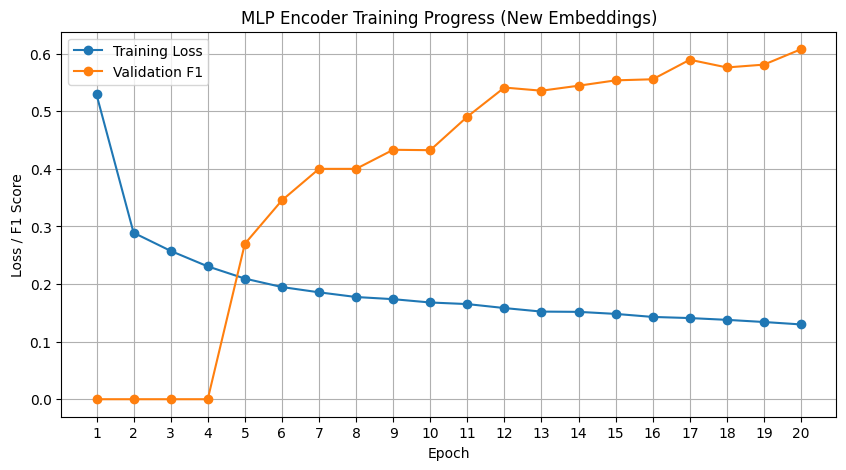

In [ ]:
# ======================================#
# 🔧 라이브러리 (필수)
# ======================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# GPU 사용 가능하면 사용, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================#
# 1️⃣ CSV 불러오기
# ======================================
try:
    trial_embed_df = pd.read_csv("/content/trial_embeddings_10k.csv")
    hpo_embed_df = pd.read_csv("/content/orphanet_embeddings_full.csv")
    training_df = pd.read_csv("/content/training_data_10k.csv")
    print("✅ 모든 새로운 CSV 파일 로드 완료!")
except FileNotFoundError:
    print("🔥🔥 오류: 필요한 새로운 CSV 파일 3개가 모두 업로드되었거나 경로가 올바른지 확인하세요.")
    trial_embed_df = None
    hpo_embed_df = None
    training_df = None


if trial_embed_df is not None and hpo_embed_df is not None and training_df is not None:
    print("Trial Embeddings (New) shape:", trial_embed_df.shape)
    print("HPO Embeddings (New) shape:", hpo_embed_df.shape)
    print("Training Data shape:", training_df.shape)

    # 벡터 부분만 numpy 배열로 추출
    trial_vecs = trial_embed_df.iloc[:, 1:].values.astype(np.float32)
    hpo_vecs = hpo_embed_df.iloc[:, 1:].values.astype(np.float32)

    # ⚠️ 보완: 딕셔너리 생성 시에도 텍스트 정규화 적용 (Step 2/3에서 정규화된 텍스트를 사용했으므로)
    # 텍스트 컬럼이 첫 번째 컬럼(인덱스 0)임을 가정합니다.
    trial_text_to_idx = {str(text): idx for idx, text in enumerate(trial_embed_df.iloc[:, 0])}
    hpo_text_to_idx = {str(text): idx for idx, text in enumerate(hpo_embed_df.iloc[:, 0])}

    embedding_dim = trial_vecs.shape[1]
    print(f"✅ 새로운 임베딩 차원: {embedding_dim}")

    # ======================================#
    # 2️⃣ 입력 시퀀스 생성
    # ======================================
    pairs = []
    labels = []
    not_found_count = 0

    print("\n⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...")

    # ⚠️ 보완: training_df에서 로드할 때 텍스트를 정규화합니다.
    # (Step 3에서 training_data.csv에 이미 정규화된 텍스트가 들어있다고 가정합니다.)

    for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 생성 중"):
        text_a = str(row['text_A'])
        text_b = str(row['text_B'])
        label = row['label']

        # 딕셔너리에서 정규화된 텍스트로 인덱스를 찾음
        idx_a = trial_text_to_idx.get(text_a)
        idx_b = hpo_text_to_idx.get(text_b)

        if idx_a is not None and idx_b is not None:
            pair_vec = np.stack([trial_vecs[idx_a], hpo_vecs[idx_b]], axis=0)
            pairs.append(pair_vec)
            labels.append(label)
        else:
            not_found_count += 1

    if not_found_count > 0:
        print(f"⚠️ 경고: {not_found_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다. (전체 {len(training_df)}개 중)")
        # 이 숫자가 5016개에서 얼마나 줄었는지 확인해야 합니다!

    pairs = np.array(pairs)
    labels = np.array(labels)

    if len(pairs) > 0:
        print(f"✅ 입력 shape: {pairs.shape} | 라벨 수: {len(labels)}")
    # ... (이하 3, 4, 5, 6 단계 코드는 동일)

        # ======================================#
        # 3️⃣ Dataset 정의
        # ======================================
        class EmbeddingDataset(Dataset):
            def __init__(self, X, y):
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y, dtype=torch.float32)
            def __len__(self): return len(self.X)
            def __getitem__(self, idx): return self.X[idx], self.y[idx]

        if len(np.unique(labels)) < 2 or np.min(np.bincount(labels)) < 2:
              print("🔥🔥 오류: 학습/테스트 데이터 분리 후 각 클래스에 샘플이 부족합니다. 데이터셋 크기를 확인하세요.")
              X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])
        else:
            X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, stratify=labels)

        if len(X_train) > 0 and len(X_test) > 0:
            train_ds = EmbeddingDataset(X_train, y_train)
            test_ds = EmbeddingDataset(X_test, y_test)

            train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=32)
            print(f"✅ 학습 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개")

            # ======================================#
            # 4️⃣ MLP 인코더 정의
            # ======================================
            class MLPVectorClassifier(nn.Module):
                def __init__(self, input_dim, hidden_dim_1=256, hidden_dim_2=64):
                    super(MLPVectorClassifier, self).__init__()
                    flattened_dim = input_dim * 2

                    self.fc1 = nn.Linear(flattened_dim, hidden_dim_1)
                    self.dropout1 = nn.Dropout(0.3)
                    self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
                    self.dropout2 = nn.Dropout(0.3)
                    self.fc3 = nn.Linear(hidden_dim_2, 1)

                def forward(self, x):
                    x = x.view(x.size(0), -1)
                    x = torch.relu(self.fc1(x))
                    x = self.dropout1(x)
                    x = torch.relu(self.fc2(x))
                    x = self.dropout2(x)
                    out = self.fc3(x)
                    return torch.sigmoid(out).squeeze(-1) if out.ndim > 1 else torch.sigmoid(out).squeeze()

            # 모델, 손실 함수, 옵티마이저 정의
            model = MLPVectorClassifier(input_dim=embedding_dim).to(device)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            print("\n✅ MLP 모델 정의 완료!")

            best_f1 = 0.0 # F1-Score 초기화

            # ======================================#
            # 5️⃣ 학습 루프 (체크포인트 저장 로직 포함)
            # ======================================
            EPOCHS = 20
            train_loss_list, val_f1_list = [], []

            print("\n⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...")
            for epoch in range(EPOCHS):
                model.train()
                total_loss = 0
                for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
                    Xb, yb = Xb.to(device), yb.to(device)

                    optimizer.zero_grad()
                    outputs = model(Xb)
                    loss = criterion(outputs, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                train_loss_list.append(avg_loss)

                # --- 검증 단계 ---
                model.eval()
                all_preds, all_labels = [], []
                with torch.no_grad():
                    for Xb, yb in test_loader:
                        Xb = Xb.to(device)
                        probs = model(Xb).cpu().numpy()
                        preds = (probs > 0.5).astype(int)

                        if preds.ndim == 0:
                            all_preds.append(int(preds))
                        else:
                            all_preds.extend(preds.tolist())

                        all_labels.extend(yb.numpy().tolist())

                f1 = f1_score(all_labels, all_preds, zero_division=0)
                val_f1_list.append(f1)

                # --- ✨ 체크포인트 저장 로직 ✨ ---
                if f1 > best_f1:
                    best_f1 = f1
                    model_path = os.path.join(MODEL_SAVE_PATH, f"MLP_best_epoch_{epoch+1}_f1_{f1:.4f}.pth")
                    torch.save(model.state_dict(), model_path)
                    print(f"  ✨ **CheckPoint 저장됨**: Epoch {epoch+1}, F1: {f1:.4f} (Google Drive)")

                print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f} (Best F1: {best_f1:.4f})")

            # ======================================#
            # 6️⃣ 최종 평가 및 시각화
            # ======================================
            print("\n=== 최종 Classification Report (Single MLP Encoder) ===")
            print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

            plt.figure(figsize=(10, 5))
            plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
            plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
            plt.title("MLP Encoder Training Progress (New Embeddings)")
            plt.xlabel("Epoch")
            plt.ylabel("Loss / F1 Score")
            plt.xticks(range(1, EPOCHS + 1))
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("🔥🔥 오류: 학습 또는 테스트 데이터셋 크기가 0입니다. 데이터 분리 설정을 확인하세요.")
    else:
        print("🔥🔥 오류: 유효한 데이터 쌍이 없어 모델 학습을 진행할 수 없습니다.")
else:
    print("🔥🔥 오류: 필요한 데이터프레임이 로드되지 않아 처리를 계속할 수 없습니다.")

임베딩 데이터 버전2로 재생성하는 과정임.

In [ ]:
# =========================================================
# Code Block 1: 임베딩 파일 재생성 (Step 2)
# 새로운 파일 이름: trial_embeddings_10k_v2.csv
# 새로운 파일 이름: orphanet_embeddings_full_v2.csv
# =========================================================
!pip install sentence-transformers tqdm
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

# 텍스트 정규화 함수 (매칭 오류 해결 핵심)
def normalize_text(text):
    if pd.isna(text):
        return ""
    # 양 끝 공백 제거, 소문자 변환, 줄 바꿈/탭 문자 제거
    return str(text).strip().lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')


# 사용할 임베딩 모델 로드
print("⏳ 임베딩 모델 로드 중...")
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
print("✅ 임베딩 모델 로드 완료!")

# --- 1. Trial 데이터 임베딩 ---
print("\n⏳ 'trials_api_10k.csv' 파일을 임베딩합니다... (텍스트 정규화 적용)")
df_trial = pd.read_csv("/content/trials_api_10k.csv")
df_trial['eligibilityCriteria_normalized'] = df_trial['eligibilityCriteria'].apply(normalize_text)
texts_trial = df_trial['eligibilityCriteria_normalized'].tolist()
# 모델 인코딩
embeddings_trial = model.encode(texts_trial, show_progress_bar=True, convert_to_numpy=True)

# 결과 저장 (파일명 변경)
embedding_df_trial = pd.DataFrame(embeddings_trial)
text_df_trial = pd.DataFrame(texts_trial, columns=['original_text'])
final_df_trial = pd.concat([text_df_trial, embedding_df_trial], axis=1)
final_df_trial.to_csv("trial_embeddings_10k_v2.csv", index=False)
print("✅ 'trial_embeddings_10k_v2.csv' 파일 재생성 완료!")


# --- 2. Orphanet 데이터 임베딩 ---
print("\n⏳ 'out4.csv' 파일을 임베딩합니다... (텍스트 정규화 적용)")
df_hpo = pd.read_csv("out4.csv")
df_hpo['HPOTERM_normalized'] = df_hpo['HPOTERM'].apply(normalize_text)
texts_hpo = df_hpo['HPOTERM_normalized'].tolist()
# 모델 인코딩
embeddings_hpo = model.encode(texts_hpo, show_progress_bar=True, convert_to_numpy=True)

# 결과 저장 (파일명 변경)
embedding_df_hpo = pd.DataFrame(embeddings_hpo)
text_df_hpo = pd.DataFrame(texts_hpo, columns=['original_hpoterm'])
final_df_hpo = pd.concat([text_df_hpo, embedding_df_hpo], axis=1)
final_df_hpo.to_csv("orphanet_embeddings_full_v2.csv", index=False)
print("✅ 'orphanet_embeddings_full_v2.csv' 파일 재생성 완료!")

⏳ 임베딩 모델 로드 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

✅ 임베딩 모델 로드 완료!

⏳ 'trials_api_10k.csv' 파일을 임베딩합니다... (텍스트 정규화 적용)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

✅ 'trial_embeddings_10k_v2.csv' 파일 재생성 완료!

⏳ 'out4.csv' 파일을 임베딩합니다... (텍스트 정규화 적용)


Batches:   0%|          | 0/3614 [00:00<?, ?it/s]

✅ 'orphanet_embeddings_full_v2.csv' 파일 재생성 완료!


In [ ]:
# 3. 1:1 균형 잡힌 학습 데이터 재생성 (V2 - 텍스트 정규화 적용, 검색 속도 최적화)
import pandas as pd
import random
import re
from tqdm import tqdm
import os
import sys # 오류 발생 시 종료를 위해 추가

# 텍스트 정규화 함수 (Step 2와 완벽히 동일해야 합니다!)
def normalize_text(text):
    if pd.isna(text):
        return ""
    # 양 끝 공백 제거, 소문자 변환, 줄 바꿈/탭 문자 제거
    return str(text).strip().lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

print("⏳ 1단계: 원본 CSV 파일들을 불러옵니다...")
# Step 1에서 생성된 trials_api_10k.csv와 원본 out4.csv를 사용합니다.
try:
    trials_df = pd.read_csv("trials_api_10k.csv")
    hpo_df = pd.read_csv("out4.csv")
    print("✅ 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 원본 파일이 없습니다. ({e}) 'trials_api_10k.csv'와 'out4.csv'를 확인하세요.")
    sys.exit(1)

# ⚠️ [수정 핵심]: 원본 텍스트에 정규화 함수를 적용
trials_criteria_raw = trials_df['eligibilityCriteria'].dropna().tolist()
hpo_terms_raw = hpo_df['HPOTERM'].dropna().tolist()

# 정규화된 텍스트 리스트 생성
trials_criteria = [normalize_text(c) for c in trials_criteria_raw]
hpo_terms = [normalize_text(t) for t in hpo_terms_raw]

training_data = []
seen_pairs = set()

# --- 긍정 예시 (Label = 1) 생성 [✨ 속도 최적화 영역] ---
print(" - 긍정 데이터 생성 중 (속도 최적화된 검색 방식)...")

# HPO 용어 (11만여 개)를 기준으로 반복하고, 각 용어가 Criteria (약 1천 개) 내에 포함되어 있는지 검사합니다.
for term in tqdm(hpo_terms, desc="HPO 용어 기준으로 긍정 데이터 검색 중"):
    if len(term) >= 3:
        for criteria in trials_criteria:
            # ⚠️ [수정]: 대규모 regex.findall 대신 Python의 빠른 'in' 연산자 사용
            if term in criteria:
                pair = (criteria, term)
                if pair not in seen_pairs:
                    training_data.append({'text_A': criteria, 'text_B': term, 'label': 1})
                    seen_pairs.add(pair)

num_positive_samples = len([d for d in training_data if d['label']==1])
print(f" - ✅ 긍정 데이터 {num_positive_samples}개 생성 완료!")


# --- 부정 예시 (Label = 0) 생성 (1:1 비율 유지) ---
print(" - 부정 데이터 생성 중 (긍정 데이터와 1:1 비율, 정규화된 텍스트 사용)...")
NUM_NEGATIVE_SAMPLES = num_positive_samples

negative_count = 0
with tqdm(total=NUM_NEGATIVE_SAMPLES, desc="부정 데이터 생성 중") as pbar:
    while negative_count < NUM_NEGATIVE_SAMPLES:
        random_criteria = random.choice(trials_criteria)
        random_term = random.choice(hpo_terms)

        # ⚠️ [검사]: 정규화된 용어의 포함 여부를 검사
        if len(random_term) >= 3 and random_term in random_criteria:
            continue

        pair = (random_criteria, random_term)
        if pair not in seen_pairs:
            training_data.append({'text_A': random_criteria, 'text_B': random_term, 'label': 0})
            seen_pairs.add(pair)
            negative_count += 1
            pbar.update(1)
print(f" - ✅ 부정 데이터 {negative_count}개 생성 완료!")

# --- 최종 CSV 파일로 저장 (파일명 변경) ---
print("\n⏳ 3단계: 'training_data_10k_v2.csv' 파일로 저장합니다...")
final_df = pd.DataFrame(training_data)
final_df = final_df.sample(frac=1).reset_index(drop=True) # 데이터 섞기
# 파일명 변경
final_df.to_csv("training_data_10k_v2.csv", index=False, encoding='utf-8-sig')

print("\n🎉🎉🎉 성공! 'training_data_10k_v2.csv' 파일이 생성되었습니다! 🎉🎉🎉")
print(f"총 {len(final_df)}개의 균형 잡힌 학습 데이터가 만들어졌습니다.")

⏳ 1단계: 원본 CSV 파일들을 불러옵니다...
✅ 파일 로드 완료!
 - 긍정 데이터 생성 중 (속도 최적화된 검색 방식)...


HPO 용어 기준으로 긍정 데이터 검색 중: 100%|██████████| 115627/115627 [06:25<00:00, 300.10it/s]


 - ✅ 긍정 데이터 6050개 생성 완료!
 - 부정 데이터 생성 중 (긍정 데이터와 1:1 비율, 정규화된 텍스트 사용)...


부정 데이터 생성 중: 100%|██████████| 6050/6050 [00:00<00:00, 90940.02it/s]


 - ✅ 부정 데이터 6050개 생성 완료!

⏳ 3단계: 'training_data_10k_v2.csv' 파일로 저장합니다...

🎉🎉🎉 성공! 'training_data_10k_v2.csv' 파일이 생성되었습니다! 🎉🎉🎉
총 12100개의 균형 잡힌 학습 데이터가 만들어졌습니다.


싱글 LSTM

✅ Device: cpu
✅ 모든 새로운 CSV 파일 로드 완료!
Trial Embeddings (New) shape: (997, 513)
HPO Embeddings (New) shape: (115627, 513)
Training Data shape: (12100, 3)
✅ 새로운 임베딩 차원: 512

⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...


데이터 쌍 생성 중: 100%|██████████| 12100/12100 [00:03<00:00, 3899.34it/s]


✅ 입력 shape: (12100, 2, 512) | 라벨 수: 12100
✅ 학습 데이터: 9680개, 테스트 데이터: 2420개

✅ LSTM 모델 정의 완료!

⏳ 모델 학습을 시작합니다...


Epoch 1/20 [학습]: 100%|██████████| 303/303 [00:05<00:00, 52.73it/s]


Epoch [1/20] | Loss: 0.6775 | Val F1: 0.7702


Epoch 2/20 [학습]: 100%|██████████| 303/303 [00:11<00:00, 27.50it/s]


Epoch [2/20] | Loss: 0.5883 | Val F1: 0.7808


Epoch 3/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 78.39it/s]


Epoch [3/20] | Loss: 0.4758 | Val F1: 0.7965


Epoch 4/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 103.47it/s]


Epoch [4/20] | Loss: 0.4361 | Val F1: 0.8040


Epoch 5/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 101.49it/s]


Epoch [5/20] | Loss: 0.4193 | Val F1: 0.8099


Epoch 6/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 98.40it/s]


Epoch [6/20] | Loss: 0.4061 | Val F1: 0.8101


Epoch 7/20 [학습]: 100%|██████████| 303/303 [00:04<00:00, 72.19it/s]


Epoch [7/20] | Loss: 0.3954 | Val F1: 0.8193


Epoch 8/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 96.13it/s] 


Epoch [8/20] | Loss: 0.3877 | Val F1: 0.8209


Epoch 9/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 103.48it/s]


Epoch [9/20] | Loss: 0.3811 | Val F1: 0.8333


Epoch 10/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 101.50it/s]


Epoch [10/20] | Loss: 0.3734 | Val F1: 0.8287


Epoch 11/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 78.44it/s]


Epoch [11/20] | Loss: 0.3701 | Val F1: 0.8411


Epoch 12/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 78.80it/s]


Epoch [12/20] | Loss: 0.3656 | Val F1: 0.8351


Epoch 13/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 103.01it/s]


Epoch [13/20] | Loss: 0.3626 | Val F1: 0.8432


Epoch 14/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 102.80it/s]


Epoch [14/20] | Loss: 0.3588 | Val F1: 0.8450


Epoch 15/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 85.48it/s]


Epoch [15/20] | Loss: 0.3541 | Val F1: 0.8422


Epoch 16/20 [학습]: 100%|██████████| 303/303 [00:04<00:00, 71.28it/s]


Epoch [16/20] | Loss: 0.3519 | Val F1: 0.8440


Epoch 17/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 99.93it/s]


Epoch [17/20] | Loss: 0.3489 | Val F1: 0.8448


Epoch 18/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 90.80it/s] 


Epoch [18/20] | Loss: 0.3456 | Val F1: 0.8453


Epoch 19/20 [학습]: 100%|██████████| 303/303 [00:03<00:00, 97.28it/s]


Epoch [19/20] | Loss: 0.3448 | Val F1: 0.8470


Epoch 20/20 [학습]: 100%|██████████| 303/303 [00:04<00:00, 71.89it/s]


Epoch [20/20] | Loss: 0.3417 | Val F1: 0.8441

=== 최종 Classification Report (Single LSTM Encoder - New Embeddings) ===
              precision    recall  f1-score   support

         0.0     0.8465    0.8388    0.8427      1210
         1.0     0.8403    0.8479    0.8441      1210

    accuracy                         0.8434      2420
   macro avg     0.8434    0.8434    0.8434      2420
weighted avg     0.8434    0.8434    0.8434      2420



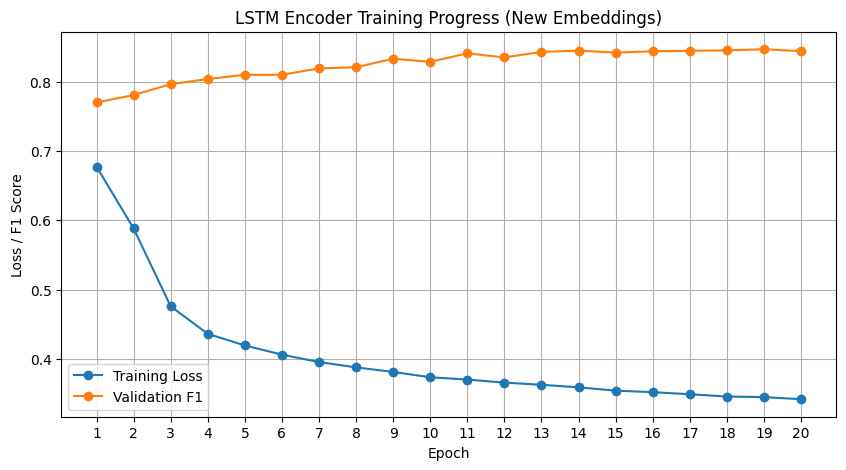

In [ ]:
# ======================================#
# 🔧 라이브러리 (Previous imports)
# ======================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# GPU 사용 가능하면 사용, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================#
# 1️⃣ CSV 불러오기 (새로운 임베딩 파일 2개 + 정답지 파일 1개 로드)
# ======================================
try:
    # Load the NEW embedding files
    trial_embed_df = pd.read_csv("/content/trial_embeddings_10k_v2.csv")
    hpo_embed_df = pd.read_csv("/content/orphanet_embeddings_full_v2.csv") # Corrected filename
    training_df = pd.read_csv("/content/training_data_10k_v2.csv")
    print("✅ 모든 새로운 CSV 파일 로드 완료!")
except FileNotFoundError:
    print("🔥🔥 오류: 필요한 새로운 CSV 파일 3개가 모두 업로드되었거나 경로가 올바른지 확인하세요.")
    # 필요한 파일이 없으면 여기서 중단
    # No exit() here, just print error as per guidelines
    # Assume dataframes are None if not loaded
    trial_embed_df = None
    hpo_embed_df = None
    training_df = None


if trial_embed_df is not None and hpo_embed_df is not None and training_df is not None:
    print("Trial Embeddings (New) shape:", trial_embed_df.shape)
    print("HPO Embeddings (New) shape:", hpo_embed_df.shape)
    print("Training Data shape:", training_df.shape)

    # 벡터 부분만 numpy 배열로 추출 (첫 컬럼 제외)
    trial_vecs = trial_embed_df.iloc[:, 1:].values.astype(np.float32)
    hpo_vecs = hpo_embed_df.iloc[:, 1:].values.astype(np.float32)

    # 원본 텍스트를 인덱스와 매핑하는 딕셔너리 생성 (벡터를 빠르게 찾기 위함)
    trial_text_to_idx = {text: idx for idx, text in enumerate(trial_embed_df['original_text'])}
    hpo_text_to_idx = {text: idx for idx, text in enumerate(hpo_embed_df['original_hpoterm'])}

    # 임베딩 차원 확인 (Adjusted for the new embeddings)
    embedding_dim = trial_vecs.shape[1] # Should be 384 now
    print(f"✅ 새로운 임베딩 차원: {embedding_dim}")

    # ======================================#
    # 2️⃣ 입력 시퀀스 생성 (✨ training_data.csv 기반으로 수정!)
    # ======================================#
    pairs = []
    labels = []
    not_found_count = 0

    print("\n⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...")
    # Using iterrows is inefficient for large data, but acceptable for 805 rows
    for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 생성 중"):
        text_a = row['text_A']
        text_b = row['text_B']
        label = row['label']

        # 각 텍스트에 해당하는 벡터의 인덱스를 찾음
        idx_a = trial_text_to_idx.get(text_a)
        idx_b = hpo_text_to_idx.get(text_b)

        # 만약 텍스트를 임베딩 파일에서 찾을 수 있다면 벡터 쌍 생성
        if idx_a is not None and idx_b is not None:
            # 두 벡터를 쌓아서 하나의 입력으로 만듦 (shape: [2, embedding_dim])
            pair_vec = np.stack([trial_vecs[idx_a], hpo_vecs[idx_b]], axis=0)
            pairs.append(pair_vec)
            labels.append(label)
        else:
            # 텍스트를 찾지 못한 경우 (오타 또는 누락) 카운트
            not_found_count += 1
            # print(f"Warning: Cannot find vector for pair: '{text_a[:30]}...' or '{text_b[:30]}...'")

    if not_found_count > 0:
        print(f"⚠️ 경고: {not_found_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다. training_data.csv와 임베딩 파일의 텍스트가 일치하는지 확인하세요.")

    # 리스트를 numpy 배열로 변환
    pairs = np.array(pairs)
    labels = np.array(labels)

    # 생성된 데이터 확인 (shape: [데이터 개수, 2, 임베딩 차원])
    if len(pairs) > 0:
        print(f"✅ 입력 shape: {pairs.shape} | 라벨 수: {len(labels)}")
    else:
        print("🔥🔥 오류: 유효한 벡터 쌍을 하나도 생성하지 못했습니다. CSV 파일들을 확인하세요.")
        # No exit() here, just print error as per guidelines
        pairs = np.array([]) # Ensure pairs is an empty array if no data
        labels = np.array([]) # Ensure labels is an empty array if no data


    if len(pairs) > 0:
        # ======================================#
        # 3️⃣ Dataset 정의 (이전과 동일)
        # ======================================
        class EmbeddingDataset(Dataset):
            def __init__(self, X, y):
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y, dtype=torch.float32)
            def __len__(self): return len(self.X)
            def __getitem__(self, idx): return self.X[idx], self.y[idx]

        # 데이터를 학습용과 테스트용으로 분리 (80% 학습, 20% 테스트)
        # Ensure there are enough samples for both classes after splitting
        if len(np.unique(labels)) < 2 or np.min(np.bincount(labels)) < 2:
             print("🔥🔥 오류: 학습/테스트 데이터 분리 후 각 클래스에 샘플이 부족합니다. 데이터셋 크기를 확인하세요.")
             X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])
        else:
            X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, stratify=labels) # stratify=labels 추가 (클래스 비율 유지)

        if len(X_train) > 0 and len(X_test) > 0:
            train_ds = EmbeddingDataset(X_train, y_train)
            test_ds = EmbeddingDataset(X_test, y_test)

            # DataLoader 설정 (데이터를 배치 단위로 묶어줌)
            train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=32)
            print(f"✅ 학습 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개")

            # ======================================#
            # 4️⃣ LSTM 인코더 정의 (이전과 동일, input_dim이 새로운 임베딩 차원으로 자동 설정됨)
            # ======================================
            class LSTMVectorEncoder(nn.Module):
                def __init__(self, input_dim, hidden_dim=128): # hidden_dim 조정 가능
                    super(LSTMVectorEncoder, self).__init__()
                    # input_dim은 벡터의 차원 (예: 384)
                    # hidden_dim은 LSTM 내부 상태의 크기
                    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
                    self.dropout = nn.Dropout(0.3) # 과적합 방지
                    self.fc = nn.Linear(hidden_dim, 1) # 최종 출력을 1개(확률)로 만듦

                def forward(self, x):
                    # x shape: (batch_size, 2, input_dim)
                    # LSTM은 마지막 시점의 hidden state (h)만 사용
                    _, (h, _) = self.lstm(x)
                    # h shape: (num_layers * num_directions, batch_size, hidden_dim)
                    # 마지막 레이어의 hidden state 사용 (h[-1])
                    h = self.dropout(h[-1])
                    out = self.fc(h)
                    # sigmoid 함수를 통해 0~1 사이의 확률값으로 변환하고, 불필요한 차원 제거
                    # Ensure output is always at least 1D
                    return torch.sigmoid(out).squeeze(-1) if out.ndim > 1 else torch.sigmoid(out).squeeze()


            # 모델, 손실 함수, 옵티마이저 정의 (input_dim is now the new embedding_dim)
            model = LSTMVectorEncoder(input_dim=embedding_dim).to(device)
            criterion = nn.BCELoss() # 이진 분류 손실 함수
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 학습률(lr) 조정 가능
            print("\n✅ LSTM 모델 정의 완료!")

            # ======================================#
            # 5️⃣ 학습 루프 (이전과 동일, 에포크 수 조정 가능)
            # ======================================
            EPOCHS = 20 # 학습 반복 횟수
            train_loss_list, val_f1_list = [], []

            print("\n⏳ 모델 학습을 시작합니다...")
            for epoch in range(EPOCHS):
                model.train() # 학습 모드
                total_loss = 0
                # tqdm으로 진행률 표시
                for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
                    Xb, yb = Xb.to(device), yb.to(device) # 데이터를 GPU/CPU로 보냄

                    optimizer.zero_grad() # 이전 그래디언트 초기화
                    outputs = model(Xb)   # 모델 예측
                    loss = criterion(outputs, yb) # 손실 계산
                    loss.backward()       # 역전파 (그래디언트 계산)
                    optimizer.step()        # 모델 파라메터 업데이트
                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                train_loss_list.append(avg_loss)

                # --- 검증 단계 ---
                model.eval() # 평가 모드
                all_preds, all_labels = [], []
                with torch.no_grad(): # 그래디언트 계산 비활성화 (메모리 절약, 속도 향상)
                    for Xb, yb in test_loader:
                        Xb = Xb.to(device)
                        probs = model(Xb).cpu().numpy() # 예측 확률값 (CPU로 이동)
                        # Fix: Ensure preds is a list of integers
                        preds = (probs > 0.5).astype(int)
                        # Ensure preds is a list, even if it's a single value
                        if preds.ndim == 0: # Handle scalar case (batch size 1)
                            all_preds.append(int(preds))
                        else: # Handle array case
                            all_preds.extend(preds.tolist())

                        all_labels.extend(yb.numpy().tolist()) # Also convert labels to list

                # F1 Score 계산
                f1 = f1_score(all_labels, all_preds, zero_division=0) # zero_division=0 추가 (0으로 나누는 경우 0점 처리)
                val_f1_list.append(f1)
                print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f}")

            # ======================================#
            # 6️⃣ 최종 평가 (이전과 동일)
            # ======================================
            print("\n=== 최종 Classification Report (Single LSTM Encoder - New Embeddings) ===")
            # 최종 테스트 결과로 Classification Report 출력 (정밀도, 재현율, F1-Score 등)
            print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

            # 학습 과정 시각화 (Loss와 F1-Score 변화)
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
            plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
            plt.title("LSTM Encoder Training Progress (New Embeddings)")
            plt.xlabel("Epoch")
            plt.ylabel("Loss / F1 Score")
            plt.xticks(range(1, EPOCHS + 1)) # x축 눈금을 정수로 표시
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("🔥🔥 오류: 학습 또는 테스트 데이터셋 크기가 0입니다. 데이터 분리 설정을 확인하세요.")
    else:
        print("🔥🔥 오류: 유효한 데이터 쌍이 없어 모델 학습을 진행할 수 없습니다.")

else:
    print("🔥🔥 오류: 필요한 데이터프레임이 로드되지 않아 처리를 계속할 수 없습니다.")

MLP

✅ Device: cpu
✅ 모든 새로운 CSV 파일 로드 완료!
Trial Embeddings (New) shape: (997, 513)
HPO Embeddings (New) shape: (115627, 513)
Training Data shape: (12100, 3)
✅ 새로운 임베딩 차원: 512

⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...


데이터 쌍 생성 중: 100%|██████████| 12100/12100 [00:01<00:00, 9696.20it/s]


✅ 입력 shape: (12100, 2, 512) | 라벨 수: 12100
✅ 학습 데이터: 9680개, 테스트 데이터: 2420개

✅ MLP 모델 정의 완료!

⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...


Epoch 1/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 193.94it/s]


  ✨ **CheckPoint 저장됨**: Epoch 1, F1: 0.7993 (Google Drive)
Epoch [1/20] | Loss: 0.6223 | Val F1: 0.7993 (Best F1: 0.7993)


Epoch 2/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 199.62it/s]


  ✨ **CheckPoint 저장됨**: Epoch 2, F1: 0.8234 (Google Drive)
Epoch [2/20] | Loss: 0.4327 | Val F1: 0.8234 (Best F1: 0.8234)


Epoch 3/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 194.05it/s]


  ✨ **CheckPoint 저장됨**: Epoch 3, F1: 0.8368 (Google Drive)
Epoch [3/20] | Loss: 0.3955 | Val F1: 0.8368 (Best F1: 0.8368)


Epoch 4/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 156.20it/s]


  ✨ **CheckPoint 저장됨**: Epoch 4, F1: 0.8421 (Google Drive)
Epoch [4/20] | Loss: 0.3808 | Val F1: 0.8421 (Best F1: 0.8421)


Epoch 5/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 141.00it/s]


  ✨ **CheckPoint 저장됨**: Epoch 5, F1: 0.8479 (Google Drive)
Epoch [5/20] | Loss: 0.3673 | Val F1: 0.8479 (Best F1: 0.8479)


Epoch 6/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 132.68it/s]


  ✨ **CheckPoint 저장됨**: Epoch 6, F1: 0.8497 (Google Drive)
Epoch [6/20] | Loss: 0.3585 | Val F1: 0.8497 (Best F1: 0.8497)


Epoch 7/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 191.30it/s]


  ✨ **CheckPoint 저장됨**: Epoch 7, F1: 0.8527 (Google Drive)
Epoch [7/20] | Loss: 0.3516 | Val F1: 0.8527 (Best F1: 0.8527)


Epoch 8/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 182.94it/s]


  ✨ **CheckPoint 저장됨**: Epoch 8, F1: 0.8549 (Google Drive)
Epoch [8/20] | Loss: 0.3439 | Val F1: 0.8549 (Best F1: 0.8549)


Epoch 9/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 136.74it/s]


  ✨ **CheckPoint 저장됨**: Epoch 9, F1: 0.8579 (Google Drive)
Epoch [9/20] | Loss: 0.3379 | Val F1: 0.8579 (Best F1: 0.8579)


Epoch 10/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 170.42it/s]


Epoch [10/20] | Loss: 0.3286 | Val F1: 0.8567 (Best F1: 0.8579)


Epoch 11/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 136.91it/s]


  ✨ **CheckPoint 저장됨**: Epoch 11, F1: 0.8617 (Google Drive)
Epoch [11/20] | Loss: 0.3250 | Val F1: 0.8617 (Best F1: 0.8617)


Epoch 12/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 142.29it/s]


  ✨ **CheckPoint 저장됨**: Epoch 12, F1: 0.8620 (Google Drive)
Epoch [12/20] | Loss: 0.3185 | Val F1: 0.8620 (Best F1: 0.8620)


Epoch 13/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 125.93it/s]


Epoch [13/20] | Loss: 0.3122 | Val F1: 0.8602 (Best F1: 0.8620)


Epoch 14/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 178.57it/s]


  ✨ **CheckPoint 저장됨**: Epoch 14, F1: 0.8631 (Google Drive)
Epoch [14/20] | Loss: 0.3083 | Val F1: 0.8631 (Best F1: 0.8631)


Epoch 15/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 185.85it/s]


  ✨ **CheckPoint 저장됨**: Epoch 15, F1: 0.8672 (Google Drive)
Epoch [15/20] | Loss: 0.3016 | Val F1: 0.8672 (Best F1: 0.8672)


Epoch 16/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 186.41it/s]


  ✨ **CheckPoint 저장됨**: Epoch 16, F1: 0.8685 (Google Drive)
Epoch [16/20] | Loss: 0.2953 | Val F1: 0.8685 (Best F1: 0.8685)


Epoch 17/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 189.49it/s]


Epoch [17/20] | Loss: 0.2912 | Val F1: 0.8664 (Best F1: 0.8685)


Epoch 18/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 187.82it/s]


  ✨ **CheckPoint 저장됨**: Epoch 18, F1: 0.8752 (Google Drive)
Epoch [18/20] | Loss: 0.2825 | Val F1: 0.8752 (Best F1: 0.8752)


Epoch 19/20 [학습]: 100%|██████████| 303/303 [00:01<00:00, 186.59it/s]


Epoch [19/20] | Loss: 0.2781 | Val F1: 0.8744 (Best F1: 0.8752)


Epoch 20/20 [학습]: 100%|██████████| 303/303 [00:02<00:00, 138.74it/s]


Epoch [20/20] | Loss: 0.2723 | Val F1: 0.8690 (Best F1: 0.8752)

=== 최종 Classification Report (Single MLP Encoder) ===
              precision    recall  f1-score   support

         0.0     0.8653    0.8760    0.8706      1210
         1.0     0.8745    0.8636    0.8690      1210

    accuracy                         0.8698      2420
   macro avg     0.8699    0.8698    0.8698      2420
weighted avg     0.8699    0.8698    0.8698      2420



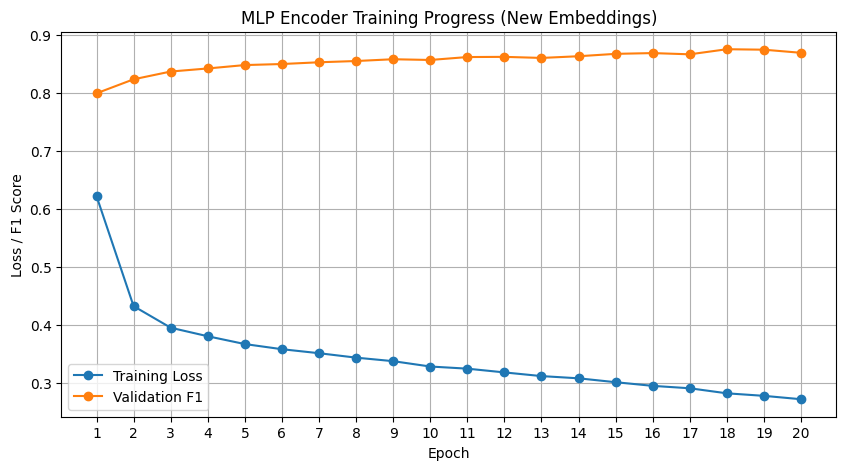

In [ ]:
# ======================================#
# 🔧 라이브러리 (필수)
# ======================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# GPU 사용 가능하면 사용, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================#
# 1️⃣ CSV 불러오기 (경로 확인 완료)
# ======================================
try:
    # Step 3에서 만든 파일 이름 사용
    trial_embed_df = pd.read_csv("/content/trial_embeddings_10k_v2.csv")
    hpo_embed_df = pd.read_csv("/content/orphanet_embeddings_full_v2.csv")
    training_df = pd.read_csv("/content/training_data_10k_v2.csv")
    print("✅ 모든 새로운 CSV 파일 로드 완료!")
except FileNotFoundError:
    print("🔥🔥 오류: 필요한 새로운 CSV 파일 3개가 모두 업로드되었거나 경로가 올바른지 확인하세요.")
    trial_embed_df = None
    hpo_embed_df = None
    training_df = None


if trial_embed_df is not None and hpo_embed_df is not None and training_df is not None:
    print("Trial Embeddings (New) shape:", trial_embed_df.shape)
    print("HPO Embeddings (New) shape:", hpo_embed_df.shape)
    print("Training Data shape:", training_df.shape)

    trial_vecs = trial_embed_df.iloc[:, 1:].values.astype(np.float32)
    hpo_vecs = hpo_embed_df.iloc[:, 1:].values.astype(np.float32)

    trial_text_to_idx = {str(text): idx for idx, text in enumerate(trial_embed_df.iloc[:, 0])}
    hpo_text_to_idx = {str(text): idx for idx, text in enumerate(hpo_embed_df.iloc[:, 0])}

    embedding_dim = trial_vecs.shape[1]
    print(f"✅ 새로운 임베딩 차원: {embedding_dim}")

    # ======================================#
    # 2️⃣ 입력 시퀀스 생성
    # ======================================
    pairs = []
    labels = []
    not_found_count = 0

    print("\n⏳ training_data.csv를 기반으로 벡터 쌍을 생성합니다...")
    for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 생성 중"):
        text_a = str(row['text_A'])
        text_b = str(row['text_B'])
        label = row['label']

        idx_a = trial_text_to_idx.get(text_a)
        idx_b = hpo_text_to_idx.get(text_b)

        if idx_a is not None and idx_b is not None:
            pair_vec = np.stack([trial_vecs[idx_a], hpo_vecs[idx_b]], axis=0)
            pairs.append(pair_vec)
            labels.append(label)
        else:
            not_found_count += 1

    if not_found_count > 0:
        print(f"⚠️ 경고: {not_found_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다.")

    pairs = np.array(pairs)
    labels = np.array(labels)

    if len(pairs) > 0:
        print(f"✅ 입력 shape: {pairs.shape} | 라벨 수: {len(labels)}")
    else:
        print("🔥🔥 오류: 유효한 벡터 쌍을 하나도 생성하지 못했습니다. CSV 파일들을 확인하세요.")
        pairs = np.array([])
        labels = np.array([])

    if len(pairs) > 0:
        # ======================================#
        # 3️⃣ Dataset 정의
        # ======================================
        class EmbeddingDataset(Dataset):
            def __init__(self, X, y):
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y, dtype=torch.float32)
            def __len__(self): return len(self.X)
            def __getitem__(self, idx): return self.X[idx], self.y[idx]

        if len(np.unique(labels)) < 2 or np.min(np.bincount(labels)) < 2:
              print("🔥🔥 오류: 학습/테스트 데이터 분리 후 각 클래스에 샘플이 부족합니다. 데이터셋 크기를 확인하세요.")
              X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])
        else:
            X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, stratify=labels)

        if len(X_train) > 0 and len(X_test) > 0:
            train_ds = EmbeddingDataset(X_train, y_train)
            test_ds = EmbeddingDataset(X_test, y_test)

            train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=32)
            print(f"✅ 학습 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개")

            # ======================================#
            # 4️⃣ MLP 인코더 정의
            # ======================================
            class MLPVectorClassifier(nn.Module):
                def __init__(self, input_dim, hidden_dim_1=256, hidden_dim_2=64):
                    super(MLPVectorClassifier, self).__init__()
                    flattened_dim = input_dim * 2

                    self.fc1 = nn.Linear(flattened_dim, hidden_dim_1)
                    self.dropout1 = nn.Dropout(0.3)
                    self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
                    self.dropout2 = nn.Dropout(0.3)
                    self.fc3 = nn.Linear(hidden_dim_2, 1)

                def forward(self, x):
                    x = x.view(x.size(0), -1)
                    x = torch.relu(self.fc1(x))
                    x = self.dropout1(x)
                    x = torch.relu(self.fc2(x))
                    x = self.dropout2(x)
                    out = self.fc3(x)
                    return torch.sigmoid(out).squeeze(-1) if out.ndim > 1 else torch.sigmoid(out).squeeze()

            # 모델, 손실 함수, 옵티마이저 정의
            model = MLPVectorClassifier(input_dim=embedding_dim).to(device)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            print("\n✅ MLP 모델 정의 완료!")

            best_f1 = 0.0 # F1-Score 초기화

            # ======================================#
            # 5️⃣ 학습 루프 (체크포인트 저장 로직 포함)
            # ======================================
            EPOCHS = 20 # 학습 반복 횟수
            train_loss_list, val_f1_list = [], []

            print("\n⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...")
            for epoch in range(EPOCHS):
                model.train()
                total_loss = 0
                for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
                    Xb, yb = Xb.to(device), yb.to(device)

                    optimizer.zero_grad()
                    outputs = model(Xb)
                    loss = criterion(outputs, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                train_loss_list.append(avg_loss)

                # --- 검증 단계 ---
                model.eval()
                all_preds, all_labels = [], []
                with torch.no_grad():
                    for Xb, yb in test_loader:
                        Xb = Xb.to(device)
                        probs = model(Xb).cpu().numpy()
                        preds = (probs > 0.5).astype(int)

                        if preds.ndim == 0:
                            all_preds.append(int(preds))
                        else:
                            all_preds.extend(preds.tolist())

                        all_labels.extend(yb.numpy().tolist())

                f1 = f1_score(all_labels, all_preds, zero_division=0)
                val_f1_list.append(f1)

                # --- ✨ 체크포인트 저장 로직 ✨ ---
                if f1 > best_f1:
                    best_f1 = f1
                    model_path = os.path.join(MODEL_SAVE_PATH, f"MLP_best_epoch_{epoch+1}_f1_{f1:.4f}.pth")
                    torch.save(model.state_dict(), model_path)
                    print(f"  ✨ **CheckPoint 저장됨**: Epoch {epoch+1}, F1: {f1:.4f} (Google Drive)")

                print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f} (Best F1: {best_f1:.4f})")

            # ======================================#
            # 6️⃣ 최종 평가 및 시각화
            # ======================================
            print("\n=== 최종 Classification Report (Single MLP Encoder) ===")
            print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

            plt.figure(figsize=(10, 5))
            plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
            plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
            plt.title("MLP Encoder Training Progress (New Embeddings)")
            plt.xlabel("Epoch")
            plt.ylabel("Loss / F1 Score")
            plt.xticks(range(1, EPOCHS + 1))
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("🔥🔥 오류: 학습 또는 테스트 데이터셋 크기가 0입니다. 데이터 분리 설정을 확인하세요.")
    else:
        print("🔥🔥 오류: 유효한 데이터 쌍이 없어 모델 학습을 진행할 수 없습니다.")
else:
    print("🔥🔥 오류: 필요한 데이터프레임이 로드되지 않아 처리를 계속할 수 없습니다.")